<a href="https://colab.research.google.com/github/ilham-mukti/Mencoba-Neural-Network/blob/main/Latihan_CNN_1_%2B_Transfer_Learning_(Data_Panorama).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jcopdl

In [ ]:
!unzip /content/data.zip

In [3]:
import torch
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block, conv_block
from jcopdl.utils.dataloader import MultilabelDataset

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = MultilabelDataset("/content/data/train_label.csv", "/content/data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = MultilabelDataset("/content/data/test_label.csv", "/content/data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [5]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# **# Arsitektur dan Config**

In [6]:
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = mobilenet_v2(pretrained=True)
    self.freeze()

    self.mnet.classifier = nn.Sequential(
        nn.Linear(1280, output_size),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.mnet(x)
  
  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [7]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size,
    'output_size': len(train_set.classes)
})

# **#1 Proses Adaptasi**

In [8]:
model = CustomMobileNetv2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir='model')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [9]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  
  cost = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
  cost = cost/len(dataset)
  return cost



Epoch    14
Train_cost  = 0.2154 | Test_cost  = 0.2407 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2158
==> Execute Early Stopping at epoch: 14 | Best test_cost: 0.2158
==> Best model is saved at model


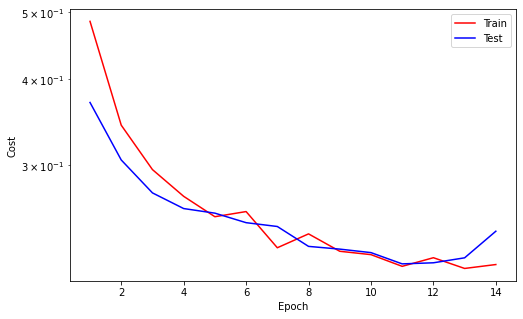

In [11]:
while True:
  train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_cost'):
    callback.plot_cost()
    break

# **#2 Fase Fine-Tuning**

In [12]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5



Epoch    15
Train_cost  = 0.2050 | Test_cost  = 0.2050 | 




Epoch    16
Train_cost  = 0.1793 | Test_cost  = 0.2000 | 




Epoch    17
Train_cost  = 0.1690 | Test_cost  = 0.1965 | 




Epoch    18
Train_cost  = 0.1619 | Test_cost  = 0.1943 | 




Epoch    19
Train_cost  = 0.1531 | Test_cost  = 0.1841 | 




Epoch    20
Train_cost  = 0.1457 | Test_cost  = 0.1846 | 


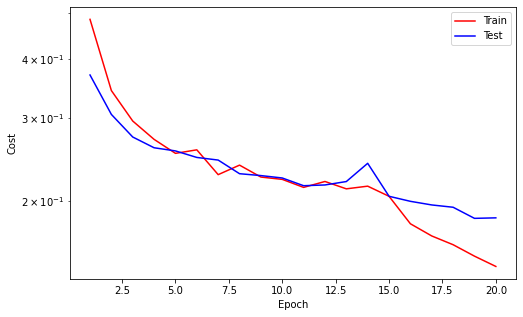

==> EarlyStop patience =  1 | Best test_cost: 0.1841




Epoch    21
Train_cost  = 0.1456 | Test_cost  = 0.1765 | 




Epoch    22
Train_cost  = 0.1356 | Test_cost  = 0.1840 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1765




Epoch    23
Train_cost  = 0.1291 | Test_cost  = 0.1819 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1765




Epoch    24
Train_cost  = 0.1254 | Test_cost  = 0.1713 | 




Epoch    25
Train_cost  = 0.1191 | Test_cost  = 0.1711 | 




Epoch    26
Train_cost  = 0.1140 | Test_cost  = 0.1696 | 




Epoch    27
Train_cost  = 0.1138 | Test_cost  = 0.1762 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1696




Epoch    28
Train_cost  = 0.1116 | Test_cost  = 0.1686 | 




Epoch    29
Train_cost  = 0.1045 | Test_cost  = 0.1697 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1686




Epoch    30
Train_cost  = 0.0978 | Test_cost  = 0.1663 | 




Epoch    31
Train_cost  = 0.0993 | Test_cost  = 0.1700 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1663




Epoch    32
Train_cost  = 0.0971 | Test_cost  = 0.1708 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1663




Epoch    33
Train_cost  = 0.0922 | Test_cost  = 0.1679 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1663




Epoch    34
Train_cost  = 0.0895 | Test_cost  = 0.1629 | 




Epoch    35
Train_cost  = 0.0891 | Test_cost  = 0.1618 | 




Epoch    36
Train_cost  = 0.0856 | Test_cost  = 0.1623 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1618




Epoch    37
Train_cost  = 0.0828 | Test_cost  = 0.1625 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1618




Epoch    38
Train_cost  = 0.0800 | Test_cost  = 0.1591 | 




Epoch    39
Train_cost  = 0.0801 | Test_cost  = 0.1585 | 




Epoch    40
Train_cost  = 0.0776 | Test_cost  = 0.1601 | 


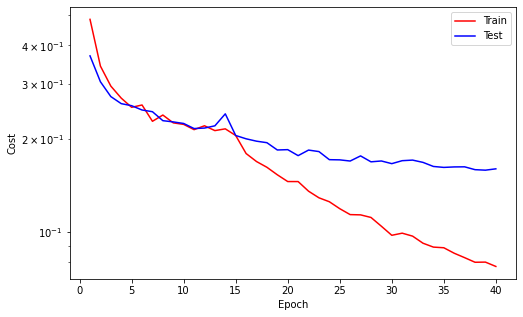

==> EarlyStop patience =  1 | Best test_cost: 0.1585




Epoch    41
Train_cost  = 0.0745 | Test_cost  = 0.1596 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1585




Epoch    42
Train_cost  = 0.0725 | Test_cost  = 0.1569 | 




Epoch    43
Train_cost  = 0.0698 | Test_cost  = 0.1702 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1569




Epoch    44
Train_cost  = 0.0667 | Test_cost  = 0.1583 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1569




Epoch    45
Train_cost  = 0.0666 | Test_cost  = 0.1530 | 




Epoch    46
Train_cost  = 0.0625 | Test_cost  = 0.1615 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1530




Epoch    47
Train_cost  = 0.0607 | Test_cost  = 0.1561 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1530




Epoch    48
Train_cost  = 0.0616 | Test_cost  = 0.1575 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1530




Epoch    49
Train_cost  = 0.0610 | Test_cost  = 0.1617 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1530




Epoch    50
Train_cost  = 0.0567 | Test_cost  = 0.1588 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1530
==> Execute Early Stopping at epoch: 50 | Best test_cost: 0.1530
==> Best model is saved at model


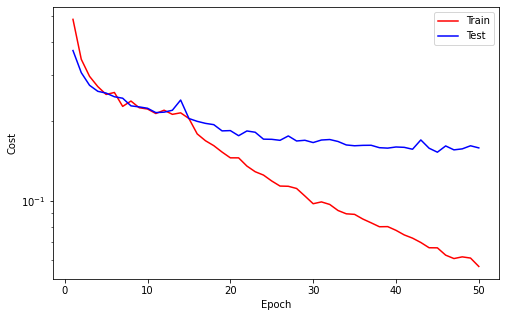

In [13]:
while True:
  train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_cost'):
    callback.plot_cost()
    break

# **Predict**

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = (output > 0.5).to(torch.float32)
preds

In [15]:
def convert_to_label(x):
  return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
  img[0, :, :] = img[0, :, :] * 0.229 + 0.485
  img[1, :, :] = img[1, :, :] * 0.224 + 0.456
  img[2, :, :] = img[2, :, :] * 0.225 + 0.406
  return img

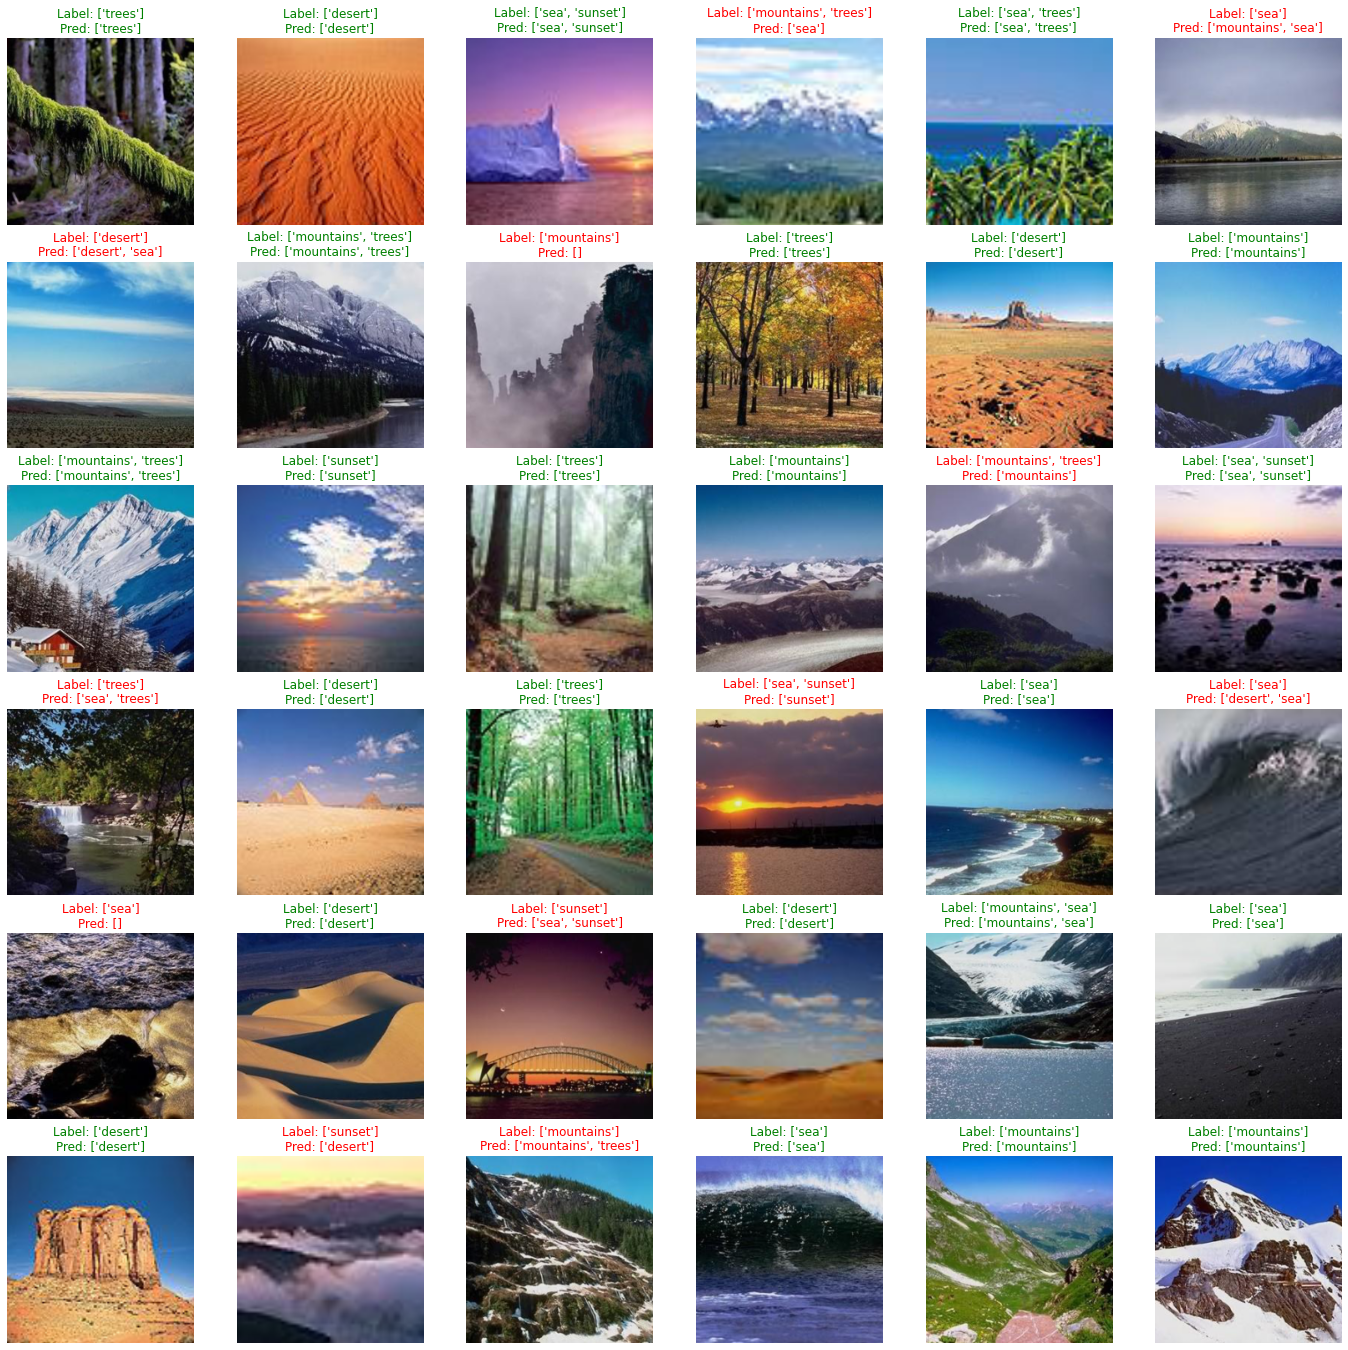

In [16]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(inverse_norm(img).permute(1,2,0).cpu())
  font = {"color":'r'} if (pred != label).any() else {"color": 'g'}
  label, pred = convert_to_label(label), convert_to_label(pred)
  ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
  ax.axis("off");